## Introduction
 
We are now ready to consider the biggest beast of them all when it comes to weather/climate hazards. Over the next few sessions, we will be working on *tropical cyclones* -- namely, the risk they currently pose (or, rather, have historically posed), and how this may change under climate warming. 

The use of the term *risk* there was not accidental. We will be going beyond simpy assessing the hazard; we will be estimating impact as measured through total finanical losses (normalised to 2018 USD [$] to account for inflation). 

To work through these important concepts, we will be following a hypothetical scenario, outlined below, in which teh US Treasury have hired you and your team as experts in tropical cyclone risk. 

### Scenario

Your task is to summarise for the Treasury the potential financial impact of tropical cyclones over the next 100 years. They have asked you to assess: 

[1] The expected annual cost of tropical cyclones to the USA, assuming no further climate change. 

[2] The cost of a very expensive (i.e., rare) year -- again in a stationary climate. The Treasury define this as a year with costs exceeded in no more than 0.5 % of years: the one-in-200-year cost. 

[3] How climate change may affect the risk

You should address the requests of the Treasury by working through the steps in this Notebook, operating in pairs/teams if you desire (but no more than three to a group). 

### Data

You will be working estimates of tropical cyclone damage from [ICAT](http://www.icatdamageestimator.com/viewdata). All costs are provided in US Dollars, adjusted for inflation to 2018 equaivalent.  

When assessing the role of climate change, you will be using data from the [ERA5 reanalysis](https://www.ecmwf.int/en/forecasts/datasets/reanalysis-datasets/era5), combined with a [model](https://gmd.copernicus.org/articles/14/2351/2021/) to estimate the maximum potential intensity of tropical cyclones. 

### Analysis

Follow the workbook to address the requests of the Treasury. Remember to run code cells when you get to them by either pressing "run" at the of the browser window, or by hitting "ctrl" + "enter" on your keyboard. 

In [52]:
# Importing and preliminaries
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from random import randint
from scipy import stats
from IPython.display import YouTubeVideo
import xarray as xa, numpy as np
from pyPI import pi
import matplotlib.pyplot as plt
from src import utils
from mpl_toolkits.basemap import Basemap

_nsim=10000
data=pd.read_csv("Data/HurricaneDamage.csv",index_col="lf_ISO_TIME",parse_dates=True)
data=data.loc[data["ND"]>0] # throw away TCs that caused no damage
data["ND"]/=1e9 # Transform cost to billions
anncost=data["ND"].resample("Y").sum()
annidx=pd.date_range(start="%.0f/01/01"%anncost.index.year[0],end="%.0f/01/01"%anncost.index.year[-1],freq="1y")
anncost=anncost.reindex(annidx)
ntc=len(data)
ny=len(anncost)
maxcost_storm=data.loc[data["ND"]==data["ND"].max()]
maxcost_year=anncost.loc[anncost==anncost.max()]
rate=ntc/ny # this is the rate for our TC occurrence model 

print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("%.0f damaging hurricanes in %.0f years"%(ntc,ny))
print("Rate = %.1f storms/year"%rate)
print("*** Cost summaries (amounts in billion, 2018 $ equivalent)***")
print("Mean annual cost is $%.1f"%anncost.mean())
print("Top ten years: ")
for i in range(10):
    print("\t[%.0f] %.0f ($%.2f)"%(i+1,(anncost.sort_values()[::-1]).index.year[i],
          (anncost.sort_values()[::-1])[i]))
print("Mean cost/storm = $%.2f"%data["ND"].mean())
print("Most costly storm = %.0f ($%.2f)"%(maxcost_storm.index.year[0],maxcost_storm["ND"][0]))
print("Top ten years ")
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
245 damaging hurricanes in 117 years
Rate = 2.1 storms/year
*** Cost summaries (amounts in billion, 2018 $ equivalent)***
Mean annual cost is $18.9
Top ten years: 
	[1] 1926 ($264.89)
	[2] 2005 ($209.24)
	[3] 1900 ($171.51)
	[4] 1915 ($124.18)
	[5] 2004 ($111.13)
	[6] 1944 ($110.44)
	[7] 1992 ($90.25)
	[8] 2012 ($83.52)
	[9] 1960 ($78.93)
	[10] 1954 ($65.42)
Mean cost/storm = $9.80
Most costly storm = 1926 ($242.75)
Top ten years 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


Take a moment to appreciate the scale of the costs we're talking about here. For context, the cost of the Furlough scheme in the UK during the Covid-19 pandemic cost ~£70 billion (i.e., just under $100 billion). 

You may recall the devestating 2005 Hurricane season (in which Hurricane Katrina devestated New Orleans); and perhaps 2012 (when Hurricane Harvey generated unbelieveable rainfall totals in Houston). But perhaps 1926 -- and the Great Miami Hurricane -- is an event you have not yet heard of. Run the code below to find out more. 

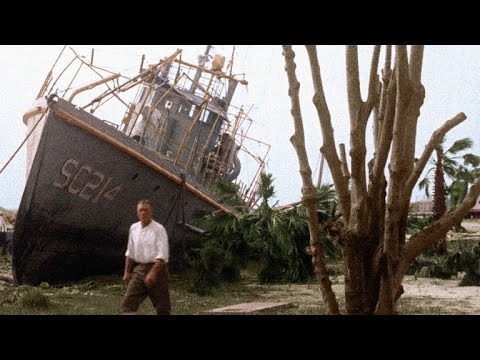

In [53]:
# A video explaining the most impactful hurricane you've never heard of. 
YouTubeVideo('LRAJ7Bc0O5E',width=800, height=500)

## The expected value

One way of estimating the expected cost is to compute the *sample* mean -- the 'average' of the annual costs. Using that approach, we already have an estimate of the expectation (in 2018 $) from the summary printed above. 

What is it?

That was easy! But is it a useful answer? Possibly not, because as shown by the histogram below, *very* large values (i.e., expensive years) are *not* that unlikley, and that can make the sample mean -- of a relatively short dataset -- unrepresentative of the expected annual cost (i.e,. the mean value we would observe if we could observe all *possible* years). 

Run the code to see the distribution of annual costs. 

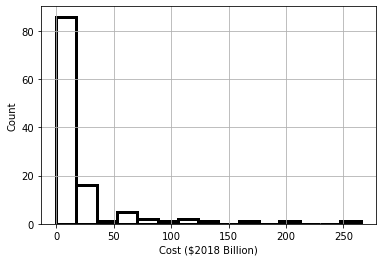

In [54]:
# Generate histogram of the annual costs
fig,ax=plt.subplots(1,1)
h=ax.hist(anncost,bins=15,facecolor='white',edgecolor='k',linewidth=3)
ax.set_ylabel("Count")
ax.set_xlabel("Cost ($2018 Billion)")
ax.grid()

To put the magnitude of variability into perspective, the maximum annual bill (\\$265 billion) is not too far short of 100 times larger than the median value ($3 billion). If such variability existed in human heights, we should expect to encounter people well over 200 m tall! Now, the possibility of such large "events" can make the mean *very* sensitive to sampling variability. To appreciate this, imagine calculating the mean height of all people in this room -- hoping it's a representative sample of all students on campus -- and then picture how that would change if a ~200 m tall student accidentally (tried) to pop in; your mean would go up -- a lot! 

We would be on a much firmer footing to compute the expected value if we knew the statistical distribution of the *population* (of heights, in this example). Knowing the population distribution is equivalent to being able to measure the heights of *all* students on campus. However, seldom can me measure all "members" of a population, so we instead make an assumption about the *probability distribution* (e.g., the Normal, GEV, etc.,) that represents the population, and use the properties of *that* to compute things like the expected value and, for eample, the probability of values beyond given thresholds (via the *CDF* -- as discussed in previous weeks).

It would be very helpful, then, to compute the expected value from the probability distribution that represents *annual costs*. We'll get into that soon; first, let's deal with a slightly simpler question: what does the distribution of *costs per cyclone* look like?  


## The distribution of cyclone impacts

The reason why we're breaking things down like this is because, when you think on the processes for a little bit, it makes sense to deal with the damage per cyclone *seperately* from the number of cylones per year. The conceptual basis is explained in [Katz (2002)](https://journals.ametsoc.org/view/journals/apme/41/7/1520-0450_2002_041_0754_smohd_2.0.co_2.xml), but one intuitive reason to seperate them is because the annual cost can equal **exactly** zero (a year in which no damaging hurricanes make landfall), *or **any** other amount*, so our final statistical model must be capable of predicting exactly zero damages, *and* any other amount -- both with the right frequency. For this reason (and some others) it turns out separating our statistical approach into models (distributions) that deal with cyclone occurrence (number of storms per year), from those which consider impact (the cost per storm), is a good idea. So, with that explainer out the way, let's get back to assessing the distribution of costs per hurricane. Run the code to take a look. 

Text(0.5, 0, 'ln{Cost ($2018 Billion)}')

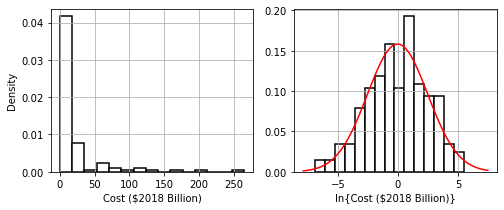

In [55]:
# Checking the fit for a log-normal distribution 
fig,ax=plt.subplots(1,2)
fig.set_size_inches(8,3)
h1=ax.flat[0].hist(anncost,bins=15,facecolor='white',edgecolor='k',linewidth=1.5,density=True)
# Taking logs of the costs/storm, and then computing the mean and stdv of the logs
lncost=np.log(data["ND"]) # log transform
lnmean=np.mean(lncost) # mean of log-transformed data
lnstd=np.std(lncost) # stdv of log-transformed data
x=np.linspace(np.min(lncost)-1,np.max(lncost)+2,100)
ax.flat[1].plot(x,stats.norm.pdf(x, loc=lnmean,scale=lnstd),color='red')
h2=ax.flat[1].hist(lncost,bins=15,density=True,facecolor='white',edgecolor='k',linewidth=1.5)
ax.flat[0].grid(); ax.flat[1].grid()
ax.flat[0].set_ylabel("Density")
ax.flat[0].set_xlabel("Cost ($2018 Billion)")
ax.flat[1].set_xlabel("ln{Cost ($2018 Billion)}")


You will see in the plots that the distribution of costs/hurricane (left) looks very similar to the cost/year distribution: it has very strong positive skew, meaning values *much* greater than the median are not that unlikely. 

The ditribution on the right, however, looks very familiar. It seems to be very well described by the Normal distribution, as shown by the way the red line (the Normal pdf) matches the histogram well. The quantity plotted in this right-hand panel is the cost/storm series *after it has been log transformed*. 

*[Note that a log transform just means "taking the logarithm" of all values in the dataset; and the logarithm of a number is the exponent that a base must be raised to in order to equal that number. For example, if the base is 10 and the number is 100, the logarithm would be 2 (as 10$^{2}$=100). In our log transform we use the base e, which has a value of ~2.71]*

The log transform has the effect of reducing larger numbers by greater amounts, and it results in our transformed data following a Normal distrubtion. Technically, this means that the underlying data follow what's called a *Log-Normal distribution*. This is great, it means that, just as we described extreme heat (in Pakistan) with the GEV distribution, it looks like we can use the Log-Normal distribution to describe the distribution of hurricane costs. 

The formula for the expected value (E[X]) from the Log-Normal distribution (given on pg. 88 of the [Wilks textbook](https://ebookcentral.proquest.com/lib/lboro/reader.action?docID=689817)) is: 

\begin{aligned}
E[X]=e^{\mu + \frac{\sigma^{2}}{2}}
\end{aligned}

where $\sigma$ and $\mu$ are the mean and standard deviation, respectively, of the *log-transformed* variable.

The equation therefore tells us that to compute the expected value (i.e., the mean) for the cost/hurricane, we simply (a) log transform the data; (b) compute the mean and standard deviation of the transformed data; and (c) plug those values into the equation above. The code below does this. Run it to find out the expected cost per hurricane. 

**What is the answer, and how does this compare with the sample average computed at the beginning of this notebook?**

In [56]:
lncost=np.log(data["ND"]) # Log transform
lnmean=np.mean(lncost) # Computing the mean of the log-transformed data
lnstd=np.std(lncost) # Computing the standard deviation of the log-transformed data
E=np.exp(lnmean+lnstd**2/2.)
print("The expected value is $%.2f billion per hurricane"%E)

The expected value is $23.06 billion per hurricane


## The number of events per yar

We now have a statistical model the cost per hurricane, but in order to estimate the expected cost per year, and the cost of a very expensive year (i.e., the one-in-200-year event), we need to also consider a statistical model for the *number of hurricanes per year*. What does this distribution look like? 

Run the code below to take a look. 

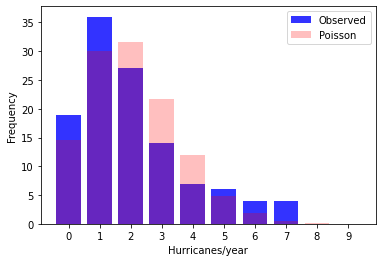

In [57]:
# Checking the Poisson distribution
# Compute the frequency with which ncylones/year are observed
x=np.arange(0,10)
of=np.array([np.sum(data.index.year==ii) for ii in anncost.index.year])
off=np.array([np.sum(of==ii) for ii in x])
gen=stats.poisson.rvs(rate,size=_nsim)
sff=np.array([np.sum(gen==ii) for ii in x])/(_nsim/ny)

fig,ax=plt.subplots(1,1)
ax.bar(x,off,color='blue',alpha=0.8,label="Observed")
ax.bar(x,sff,color='red',alpha=0.25,label="Poisson")
ax.set_xticks(x)
ax.set_xlabel("Hurricanes/year")
ax.set_ylabel("Frequency")
ax.legend()

#x=np.arange(0,11)
#ax.bar(x, stats.poisson.pmf(x, rate), label='poisson pmf')


You will again observe a distribution with positive skew, albeit much less pronounced than in the costs dataset. Although it's not a perfect match, you should additionally notice that the *Poisson* distribution is a reasonably good fit to our data. It succeeds in reproducing the basic shape of our histogram. 

As explained by [Katz (2002)](https://journals.ametsoc.org/view/journals/apme/41/7/1520-0450_2002_041_0754_smohd_2.0.co_2.xml), the Poisson distribution is also theoretically suited to describing the annual frequency of damaging hurricanes, so we will persist with its use here. 

Conveniently, the expected value (E[N]) for the Poisson distribution (i.e., the average number of damaging hurricanes per year) is simply the mean *observed* frequency, known as the "rate". We'll denote this quantity $\lambda$. 

**What is the value for $\lambda$ here? (Hint look at the stats printed out at the top of this notebook)**.

Once we have determined $\lambda$, we can compute the *expected cost per year* (E[Cy]) by combining the expected value for cost/hurricane E[Ch]) with the expected value of the number of hurricanes per year (E[N]):

\begin{aligned}
E[Cy]=\lambda e^{\mu + \frac{\sigma^{2}}{2}}
\end{aligned}

In other words, we just multiply the two expected values together! 

Run the code below to evaluate the expected cost below and print the number to screen.

In [58]:
Ecy=np.exp(np.mean(lncost)+lnstd**2/2)*rate
print("The expected cost is $%.2f billion/year"%Ecy)

The expected cost is $48.29 billion/year


## The magnitude of the one-in-200-year event

The answer above addresses the first request of the Treasury. We must now turn out attention to their second question. How severe should we expect the costs of hurricane damage to be in a very *bad* year? 

This is harder to address with simple formuale, so we will approach the problem via a statistical *simulation*, where we generate a very long sequence of "possible years" that are statistically consistent with our observations. We then summarise the plausible scenario via simple descriptive statistics. 

The algorithm to implement this should be quite intuitive. For each year, we will:

[1] Select a random number from the Posisson distribution to represent the number of damaging hurricanes in that year 

[2] Draw a random number from the Log-Normal distribution to represent its damage

[3] Add up the damage from all hurricanes in the year to obtain the total damage. 


If we do this for many, many years (say 100,000), we should get a very good idea of what's likely for the 1-in-200 year event (because we will experience 500 events as 'extreme' in the 100,000 year series). Computing the 99.5th percentile from the simulated timeseries provides us with the estimate of the 1-in-200 year event. 

When you have read (and understood) the above, run the code below to generate some plausible scenarios! 

Once the simulations are complete a timeseries plot showing all the plausible years is plotted, and the 99.5th percentile is printed to screen. For reference, we also highlight (with a red line) the most costly year in the observations (1926). 

 99.5th percentile/1-in-200-year event would be $1169.35 billion


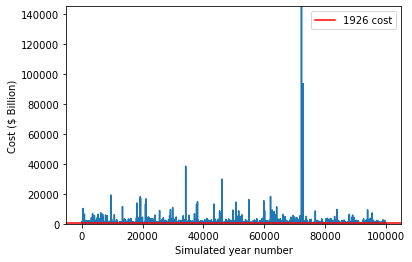

In [59]:
# Stochastic simulation
nsim=100000# This sets the number of years in our simulation
nstorms=np.zeros(nsim,dtype=np.int)
cost=np.zeros(nsim)
for i in range(nsim):
    nstorms[i]=int(stats.poisson.rvs(rate))
    cost[i]=np.sum(np.exp(stats.norm.rvs(loc=lnmean,scale=lnstd,
                                         size=nstorms[i])))
fig,ax=plt.subplots(1,1)
ax.plot(cost)
ax.set_xlabel("Simulated year number")
ax.set_ylabel("Cost ($ Billion)")
ax.axhline(anncost.max(),color='red',label="1926 cost")
ax.set_ylim(0,np.max(cost))
ax.legend()
print(" 99.5th percentile/1-in-200-year event would be $%.2f billion"%np.percentile(cost,99.5))

You will all get slightly different answers for the above due the randomness of the simulation, but with a large enough value for nsim, I expect you are unlikley to differ by more than ~20 %. 


## Climate Change

We are now ready to tackle the thorny issue of climate change: how *may* the cost of tropical cyclone impacts change? The approach we will take here is simple. We will take the weather conditions observed during the very costly 2005 hurricane season, and then "add on" some climate warming -- an amount of our choosing -- to see what impact this could have on tropical cyclone maximum intensity. We compute maximum potential intensity using a [simple model] that works out how powerful a cyclone could get, given the atmospheric state. Computing the % change in the 99th percentile of potential intensities (communicated in terms of maximum sustained wind speeds) -- between 2005 and our warmer climate -- enables use to estimate how strong tropical cyclones are likely to change with warming. 

How do we translate this increase in intensity to a change in economic impacts? A [study](https://iopscience.iop.org/article/10.1088/1748-9326/ab9be2) in the Western Pacific provides us with a simple rule of thumb: if wind speed increases by a factor of $x$, economic losses increase by a factor or $x^{1.70}$. We will use that here, but let's be clear: it is a rather crude approximation, and so provides no more that a first approximation of potential impacts.

So, to summarise, we work out how much intensity (the 99th percentile of maximum wind speed) is likely to change in a climate $n$ degrees warmer than 2005 (call this factor $x$); and we then compute $x^{1.70}$ to evaluate the increase in economic damages. For example, if $x$ = 1.25 for a climate state ($n$) = 2$^{\circ}$C warmer than 2005, the increase in economic damage (relative to 2005) would be by a factor of 1.25$^{1.70}$=1.46 = 46%

To compute the expected change in economic impact as a function of warming amount, you just need to set a warming amount in the code below (i.e., a value for $n$). This variable is referred to as "dsst" in the below: set this and run the code to see how climate warming may affect economic damage. 

In [60]:
fin="Data/era5_tc_ilev.nc"
data=xa.open_dataset(fin)
data["msl"]=data["msl"]/100. #hPa
nt,nlev,nr,nc=data["t"].shape
t=data["t"].values
q=data["q"].values
p=data["level"].values
sst=data["sst"].values
data["t"]-=273.15
data["sst"]-=273.15
result = xa.apply_ufunc(
        pi,
        data['sst'], data['msl'], data['level'], data['t'], data['q'],
        kwargs=dict(CKCD=0.9, ascent_flag=0, diss_flag=1, ptop=50, miss_handle=1),
        input_core_dims=[
            [], [], ['level', ], ['level', ], ['level', ],
        ],
        output_core_dims=[
            [], [], [], [], []
        ],
        vectorize=True
    )
vmax, pmin, ifl, t0, otl = result
vmaxold=np.nanpercentile(vmax,99)
print("The 99th percentile is %.1fm/s"%vmaxold)

The 99th percentile is 106.2m/s


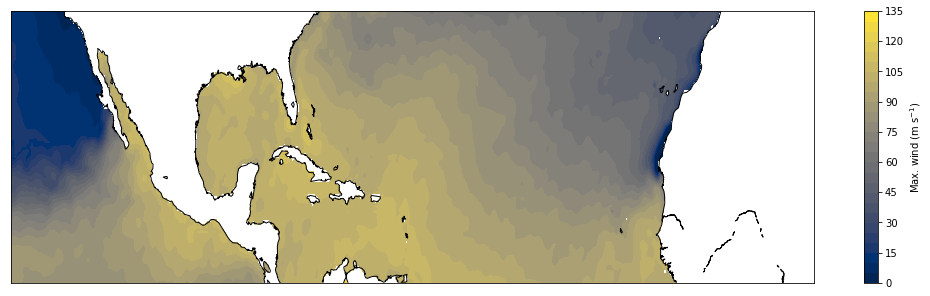

In [61]:
fig=plt.figure(figsize=(18,5))
m = Basemap(llcrnrlon=data.longitude.min(),llcrnrlat=data.latitude.min(),
            urcrnrlon=data.longitude.max(),urcrnrlat=data.latitude.max(),\
            rsphere=(6378137.00,6356752.3142),\
            resolution='l',projection='merc',\
            lat_0=40.,lon_0=-20.,lat_ts=20.,fix_aspect=False)
m.drawcoastlines()
x,y=np.meshgrid(data.longitude.values[:],data.latitude.values[:])
x,y=m(x,y)
plot=m.contourf(x,y,vmax.max(axis=0),cmap="cividis",levels=30)
plt.colorbar(label="Max. wind (m s$^{-1}$)")

In [63]:
# * * * * * * * * * * * * *
# C H A N G E    M E
dsst=2
# * * * * * * * * * * * * *
dt=dsst*1.
drh=0
sst_out,t_out,rh_out,q_out=utils.gen_future_conditions(dsst,dt,drh,sst+273.15,t+273.15,q,p,nt,nlev,nr,nc)
data["t"].values=t_out-273.15
data["sst"].values=sst_out-273.15
data["q"].values=q_out
result = xa.apply_ufunc(
        pi,
        data['sst'], data['msl'], data['level'], data['t'], data['q'],
        kwargs=dict(CKCD=0.9, ascent_flag=0, diss_flag=1, ptop=50, miss_handle=1),
        input_core_dims=[
            [], [], ['level', ], ['level', ], ['level', ],
        ],
        output_core_dims=[
            [], [], [], [], []
        ],
        vectorize=True
    )
vmax, pmin, ifl, t0, otl = result
vmaxnew=np.nanpercentile(vmax,99)
print("The 99th percentile is %.1fm/s"%vmaxnew)
factor=vmaxnew/vmaxold
print("\n\nThe increase is therefore by a factor of %.2f"%factor)
increase=factor**1.70
print("\t...meaning that the increase in cost would be by a factor of %.2f"%increase)

The 99th percentile is 115.9m/s


The increase is therefore by a factor of 1.09
	...meaning that the increase in cost would be by a factor of 1.16


In [ ]:
fig=plt.figure(figsize=(18,5))
m = Basemap(llcrnrlon=data.longitude.min(),llcrnrlat=data.latitude.min(),
            urcrnrlon=data.longitude.max(),urcrnrlat=data.latitude.max(),\
            rsphere=(6378137.00,6356752.3142),\
            resolution='l',projection='merc',\
            lat_0=40.,lon_0=-20.,lat_ts=20.,fix_aspect=False)
m.drawcoastlines()
x,y=np.meshgrid(data.longitude.values[:],data.latitude.values[:])
x,y=m(x,y)
plot=m.contourf(x,y,vmax.max(axis=0),cmap="cividis",levels=30)
plt.colorbar(label="Max. wind (m s$^{-1}$)")

In [ ]:
data

In [ ]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([data.latitude.max(), data.longitude.min(), 
               data.latitude.max(),data.longitude.max()], crs=ccrs.PlateCarree())
#ax.stock_img()
ax.coastlines()

Can you explain what is going on?

What lessons can be learned regarding climate risk?

Covid is another fat-tailed risk. 

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7533687/